In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Read data

In [33]:
df_train = pd.read_csv('stream_quality_data/train_data.csv')
df_test = pd.read_csv('stream_quality_data/test_data.csv')

# 2. Data Exploration

In [34]:
print('Number of rows and columns in the training data set: ',df_train.shape)
df_train.head(5)

Number of rows and columns in the training data set:  (406572, 12)


,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


In [35]:
types = df_train.dtypes
print("Number categorical featues:", sum(types=='object'))
print(types)

Number categorical featues: 2
fps_mean               float64
fps_std                float64
fps_lags                 int64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
auto_bitrate_state      object
auto_fec_state          object
auto_fec_mean          float64
stream_quality           int64
dtype: object


In [36]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
fps_mean,406572.0,3.449756e+01,1.162549e+01,0.0,28.300000,30.000000,43.000000,1.271000e+02
fps_std,406572.0,2.285486e+00,3.708531e+00,0.0,0.316228,0.994429,2.590581,3.125408e+02
fps_lags,406572.0,1.831508e-01,1.099384e+00,0.0,0.000000,0.000000,0.000000,1.000000e+01
rtt_mean,406572.0,5.431440e+01,1.338721e+02,0.0,14.100000,32.300000,57.100000,1.289840e+04
rtt_std,406572.0,1.952502e+01,1.563643e+02,0.0,0.699206,1.490712,5.334375,4.072193e+04
dropped_frames_mean,406572.0,1.730432e+06,4.930091e+07,0.0,0.000000,0.000000,0.000000,2.097289e+09
dropped_frames_std,406572.0,1.378279e+05,9.229776e+06,0.0,0.000000,0.000000,0.000000,9.963751e+08
dropped_frames_max,406572.0,1.893339e+06,5.241003e+07,0.0,0.000000,0.000000,0.000000,2.097289e+09
auto_fec_mean,406572.0,5.141354e+01,3.483604e+01,0.0,50.000000,50.000000,50.000000,2.500000e+02
stream_quality,406572.0,6.846020e-02,2.525343e-01,0.0,0.000000,0.000000,0.000000,1.000000e+00


In [37]:
df_train.isna().sum()

fps_mean               0
fps_std                0
fps_lags               0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
auto_bitrate_state     0
auto_fec_state         0
auto_fec_mean          0
stream_quality         0
dtype: int64

No missing values, 2 categorical features

## 3. Data Preprocessing

### Encoding the categorical features

In [38]:
from sklearn.preprocessing import LabelEncoder


# extracting the names of categorical features
cat_feats = df_train.select_dtypes(include=['object']).columns.tolist()

encoder = LabelEncoder()

# creating a copy of dataset to save our initial data
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

# fit and transform the data 
for name in cat_feats:
    encoder.fit(df_train[name])
    df_train_encoded[name] = encoder.transform(df_train[name])
    df_test_encoded[name] = encoder.transform(df_test[name])

### TrainTest splitting

In [39]:
x_train, y_train, x_test, y_test = df_train_encoded.iloc[:, :-1], df_train_encoded.iloc[:, -1],\
                                   df_test_encoded.iloc[:, :-1], df_test_encoded.iloc[:, -1]

print(x_train.shape, x_test.shape)

(406572, 11) (243596, 11)


### Features Scaling

In [40]:
# function for scaling
def scaler(scaler_name, x_train, x_test):
    """ 
        This function scales our features by using scaler_name method.
        For example, scaler_name can be MinMaxScaler or StandartScaler, or any other.    
    """
    scaler = scaler_name()
    # fit it to the data.
    scaler.fit(x_train)
    # transform the data
    scaled_data_train = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
    scaled_data_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

    return scaled_data_train, scaled_data_test

In [41]:
from sklearn.preprocessing import MinMaxScaler


scaled_data_train, scaled_data_test = scaler(MinMaxScaler, x_train, x_test)

## 5. Data Visualization

### PCA

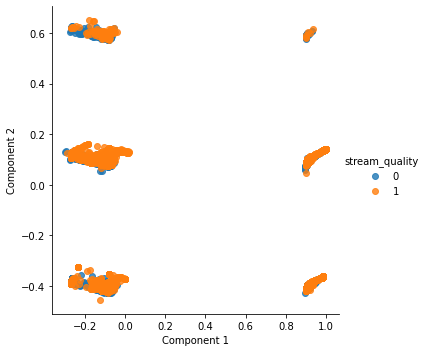

In [42]:
import seaborn as sns
from sklearn.decomposition import PCA


dim_reducer = PCA(n_components=2)
x_train_reduced = dim_reducer.fit_transform(scaled_data_train)
df_pca = pd.DataFrame(x_train_reduced, columns = ['Component1', 'Component2'])
df_pca['stream_quality'] = y_train


ax = sns.lmplot(x = 'Component1', y  = 'Component2', hue = 'stream_quality', data = df_pca, fit_reg = False)
ax.set_xlabels('Component 1')
ax.set_ylabels('Component 2')

## 6. Feature Selection

In [43]:
len_df = len(scaled_data_train)
unique_vlaues_in_columns = scaled_data_train.nunique()

columns_with_constant_value = scaled_data_train.columns[unique_vlaues_in_columns <= 1]
print("Columns with constant value:", columns_with_constant_value.tolist())

threshold = 0.99
columns_with_distinct_values = scaled_data_train.columns[unique_vlaues_in_columns / len_df > threshold]
print(f"Columns with {threshold * 100} % distinct values: {columns_with_distinct_values.tolist()}")

Columns with constant value: []
Columns with 99.0 % distinct values: []


### Correlation

<AxesSubplot:>

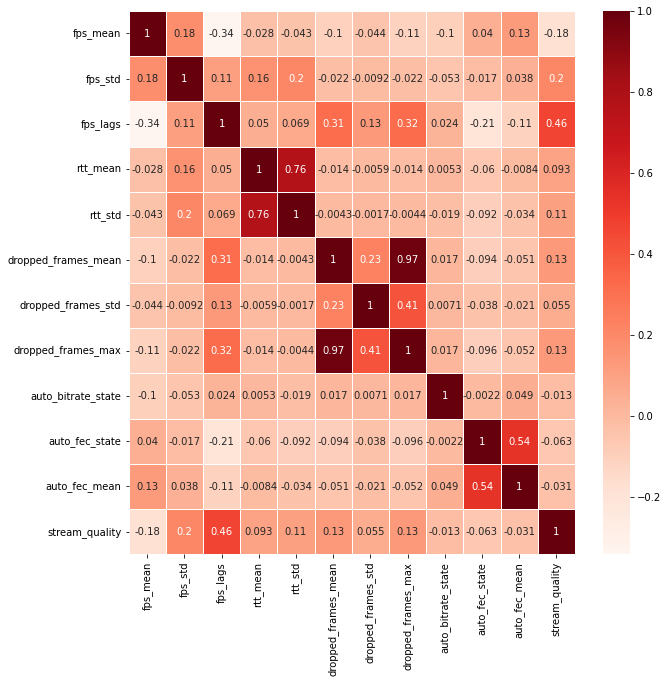

In [44]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(df_train_encoded.corr(), annot=True, cmap=plt.cm.Reds, linewidths=.5, ax=ax)

### VIF- Variance Inflation Factor - measure of the amount of multicollinearity

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# VIF dataFrame
vif_data = pd.DataFrame()
vif_data['feature'] = x_train.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(len(x_train.columns))]

print(vif_data)

                feature        VIF
0              fps_mean   6.422491
1               fps_std   1.550838
2              fps_lags   1.222571
3              rtt_mean   2.792360
4               rtt_std   2.500245
5   dropped_frames_mean  71.488734
6    dropped_frames_std   4.397023
7    dropped_frames_max  81.867632
8    auto_bitrate_state   4.218060
9        auto_fec_state   8.774668
10        auto_fec_mean   4.497278


We can see very large values for "dropped_max" and "dropped_mean". According to VIF, they have correlation with each other, what can be proved by looking at the correlation matrix as well.

### Lasso feature selection

In [46]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty = 'l1', solver = 'liblinear').fit(scaled_data_train, y_train)
log.coef_

array([[-3.28308449, 35.25739687,  8.35280934,  7.66563654,  0.        ,
         0.        ,  0.        ,  0.88059621, -0.55773162,  0.52137027,
         0.13688333]])

We can see that Lasso chose only 3 feature as meaningless, that is "rtt_std", "dropped_frames_mean", and "dropped_frames_std".

In [47]:
# removing the features from training and test set
remove_columns = ["rtt_std", "dropped_frames_mean", "dropped_frames_std"]

x_train_reduced = scaled_data_train.drop(remove_columns, axis = 1)
x_test_reduced = scaled_data_test.drop(remove_columns, axis = 1)

print(f"\nThe shape of reduced training set: {x_train_reduced.shape}")
print(f"The shape of reduced test set: {x_test_reduced.shape}")


The shape of reduced training set: (406572, 8)
The shape of reduced test set: (243596, 8)


### VIF after reducing features

In [48]:
# VIF dataFrame
vif_data = pd.DataFrame()
vif_data['feature'] = x_train_reduced.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(x_train_reduced.values, i) for i in range(len(x_train_reduced.columns))]

print(vif_data)

              feature       VIF
0            fps_mean  6.400327
1             fps_std  1.526516
2            fps_lags  1.222486
3            rtt_mean  1.189049
4  dropped_frames_max  1.123947
5  auto_bitrate_state  4.213861
6      auto_fec_state  8.746183
7       auto_fec_mean  4.497185


After reducing multicollinear features VIF decreased.

# Machine Learning Models

In [53]:
import sklearn.metrics as sm 
from sklearn.linear_model import LogisticRegression

In [54]:
# function for printing metrics for classifications
def performance_measurement_classification(y_test, y_pred):
    """ This function prints MSE, MAE, RMSE and R^2-Score metrics for train and test datasets"""

    print('Accuracy: ', sm.accuracy_score(y_test, y_pred))
    print('Precision: ', sm.precision_score(y_test, y_pred))
    print('Recall: ', sm.recall_score(y_test, y_pred))
    print("F1-Score:", sm.f1_score(y_test, y_pred))

### Logistic Regression

In [55]:
def logistic_regression(x_train, y_train, x_test, penalty="l2", solver = "liblinear"):
    """
        Function for fitting and predicting by using logistic regression.
        penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
        solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
     """

    log_reg = LogisticRegression(penalty = penalty, solver = solver)
    log_reg.fit(x_train, y_train)
    y_pred = log_reg.predict(x_test)

    return y_pred

In [56]:
y_pred_log = logistic_regression(x_train_reduced, y_train, x_test_reduced, 'none', "lbfgs")

performance_measurement_classification(y_test, y_pred_log)

c:\Users\Айнура\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9405983677892905
Precision:  0.7083049693669162
Recall:  0.13259844526570663
F1-Score: 0.22337913267496778


### Logistic Regression with L1 Regularization

In [57]:
y_pred_log_l1 = logistic_regression(x_train_reduced, y_train, x_test_reduced, 'l1', "liblinear")

performance_measurement_classification(y_test, y_pred_log_l1)

Accuracy:  0.9405408955812082
Precision:  0.7081899518238128
Recall:  0.1311329170383586
F1-Score: 0.22129032258064515


### Logistic Regression with L2 Regularization

In [58]:
y_pred_log_l2 = logistic_regression(x_train_reduced, y_train, x_test_reduced, 'l2', "liblinear")

performance_measurement_classification(y_test, y_pred_log_l2)

Accuracy:  0.9408036256752984
Precision:  0.725886524822695
Recall:  0.13043201223397477
F1-Score: 0.22112995570919305


We can compare these models by identifying what mertic is more important for this particular task.
For our task the precision is more important, I think, because we don't want FalsePositives occurance.

Then Logistic Regression with L2 Regularization has better result than others. 

# Outlier Detection

In [59]:
from sklearn.neighbors import LocalOutlierFactor


lof = LocalOutlierFactor()
yhat = lof.fit_predict(x_train)

# select all rows that are not outliers
mask = yhat != -1
x_train_without_outliers, y_train_without_outliers = x_train[mask], y_train[mask]

Counting the percentage of outliers

In [60]:
unique_values, counts = np.unique(yhat, return_counts = True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")

percentage =  counts[0] / len(x_train) * 100
print(f"The percentage of outliers is {percentage:.2f}%")

Unique values: [-1  1], Amount accordingly: [ 15651 390921]
The percentage of outliers is 3.85%


## Preprocessing

In [61]:
scaled_train_without_outliers, scaled_test = scaler(MinMaxScaler, x_train_without_outliers, x_test)

## Removing the same features

In [62]:
x_train_reduced_without_outliers = scaled_train_without_outliers.drop(remove_columns, axis = 1)
x_test_reduced = scaled_test.drop(remove_columns, axis = 1)

## Logistic Regression

In [63]:
y_pred_log_without_outliers = logistic_regression(
    x_train_reduced_without_outliers,
    y_train_without_outliers,
    x_test_reduced,
    "none",
    "lbfgs",
)

performance_measurement_classification(y_test, y_pred_log_without_outliers)

c:\Users\Айнура\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9405983677892905
Precision:  0.6934260429835651
Recall:  0.1397986491652861
F1-Score: 0.23268639304274047


Classifying without outliers increased F1-Score.

## Balancing detecting

In [64]:
unique_values, counts = np.unique(y_train_without_outliers, return_counts = True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")

Unique values: [0 1], Amount accordingly: [365285  25636]


We see that class "1" is less in the number of samples than class "0"

#### Undersampling

In [65]:
from imblearn.under_sampling import RandomUnderSampler


# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus= rus.fit_resample(x_train_without_outliers, y_train_without_outliers)
# Check the number of records after under sampling

unique_values, counts = np.unique(y_train_rus, return_counts = True)
print(f"Unique values: {unique_values}, Amount accordingly: {counts}")

Unique values: [0 1], Amount accordingly: [25636 25636]


In [66]:
# scaling
scaled_train_without_outliers, scaled_test = scaler(MinMaxScaler, x_train_rus, x_test)

# removing the dame features
x_train_reduced_without_outliers = scaled_train_without_outliers.drop(remove_columns, axis = 1)
x_test_reduced = scaled_test.drop(remove_columns, axis = 1)

# logistic regression
y_pred_log_without_outliers = logistic_regression(x_train_reduced_without_outliers, y_train_rus, x_test_reduced, 'none', "lbfgs")

performance_measurement_classification(y_test, y_pred_log_without_outliers)

Accuracy:  0.8825678582571143
Precision:  0.2757710475131981
Recall:  0.5059258315279724
F1-Score: 0.35696623656880816


F1-Score is increased, what means that the undersampling helped us to improve our model.